In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pycomlink as pycml

# Rain rate dependent WAA based on Leijnse et al 2008

[Leijnse et al 2008](https://doi.org/10.1016/j.advwatres.2008.03.004) proposes a WAA parametrization based on a thin water film with rain rate dependent thickness on the antenna.

## R vs. WAA relation

Here we look at the resulting WAA for different frequencies and different rain rates 

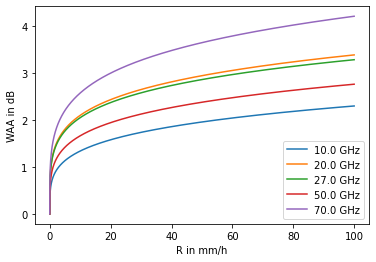

In [3]:
R = np.arange(0, 100, 0.01)

fig, ax = plt.subplots()

for f in [10, 20, 27, 50, 70]:
    waa = pycml.processing.wet_antenna.waa_leijnse_2008(f_Hz=f*1e9, R=R)
    ax.plot(R, waa, label='%2.1f GHz' % f)
ax.legend()
ax.set_xlabel('R in mm/h')
ax.set_ylabel('WAA in dB')
plt.show()

## A_obs vs. WAA relation

Since CMLs do not directly yield the rain rate `R` we want to derive the WAA from the observed attenuation `A_obs`.

This can be done by deriving the relation between `A_rain` and `waa`, where `A_rain` is calculated from `R` via the A-R relation for a given CML frequency and length. Combining `A_rain` and `waa` we get `A_obs`. In the following we will use this data to build a look-up-table (we actually use an interpolator here) to derive `waa` from any new value of `A_obs`.

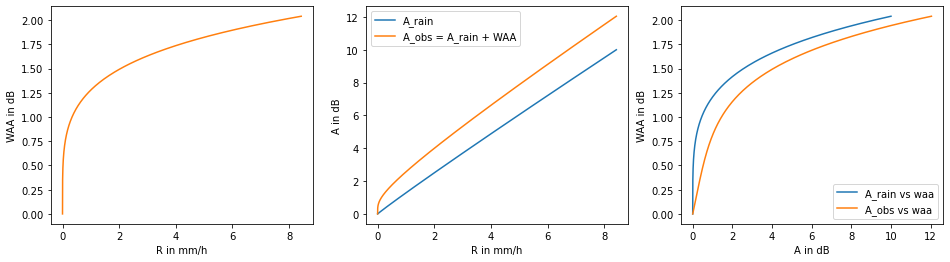

In [4]:
f_GHz = 23.0

A_rain = np.logspace(-11, 1, 1000)
A_rain[0] = 0

R = pycml.processing.k_R_relation.calc_R_from_A(A_rain, L_km=10.0, pol='V', f_GHz=f_GHz, R_min=0)
waa = pycml.processing.wet_antenna.waa_leijnse_2008(f_Hz=f_GHz*1e9, R=R)
A_obs = A_rain + waa

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
ax = axs[0]
ax.plot(R, waa, color='C1')
ax.set_xlabel('R in mm/h')
ax.set_ylabel('WAA in dB')

ax = axs[1]
ax.plot(R, A_rain, label='A_rain')
ax.plot(R, A_obs, label='A_obs = A_rain + WAA')
ax.set_xlabel('R in mm/h')
ax.set_ylabel('A in dB')
ax.legend()

ax = axs[2]
ax.plot(A_rain, waa, label='A_rain vs waa')
ax.plot(A_obs, waa, label='A_obs vs waa')
ax.set_xlabel('A in dB')
ax.set_ylabel('WAA in dB')
ax.legend();

## Relative contribution of WAA to observed attenuation

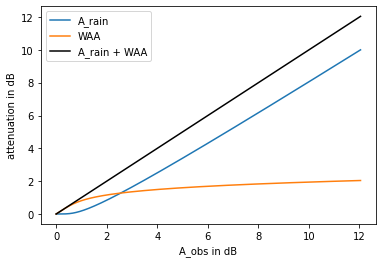

In [5]:
plt.plot(A_obs, A_rain, label='A_rain')
plt.plot(A_obs, waa, label='WAA');
plt.plot(A_obs, A_rain + waa, color='k', label='A_rain + WAA');
plt.xlabel('A_obs in dB')
plt.ylabel('attenuation in dB')
plt.legend();

## Look-up-table function to calculate WAA from A_obs

In [6]:
def waa_from_A_obs(A_obs, L, f_GHz):
    # Generate mapping from A_obs to WAA
    A_rain = np.logspace(-10, 3, 100)
    A_rain[0] = 0
    
    R = pycml.processing.k_R_relation.calc_R_from_A(A_rain, L_km=L, f_GHz=f_GHz, pol='V', R_min=0)
    waa = pycml.processing.wet_antenna.waa_leijnse_2008(f_Hz=f_GHz*1e9, R=R)
    A_obs_theoretical = A_rain + waa
    
    mapping = scipy.interpolate.interp1d(A_obs_theoretical, waa, assume_sorted=True, kind='linear')
    return mapping(A_obs)

waa_from_A_obs(np.arange(10), L=10, f_GHz=23)

array([0.        , 0.81188097, 1.15716775, 1.35323596, 1.49116094,
       1.5986414 , 1.68919034, 1.76213777, 1.82985324, 1.88777153])

The same functionality is also available directly in `pycomlink`

In [7]:
pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(np.arange(10), L_km=10, pol='V', f_Hz=23e9)

array([0.        , 0.81188097, 1.15716775, 1.35323596, 1.49116094,
       1.5986414 , 1.68919034, 1.76213777, 1.82985324, 1.88777153])

## Check if the WAA derived from the look-up-table (LUT) function fits the WAA from the equations 

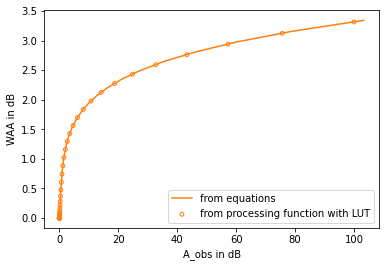

In [8]:
L_km = 10
f_Hz = 23e9

A_rain = np.logspace(-10, 2, 100)
A_rain[0] = 0

R = pycml.processing.k_R_relation.calc_R_from_A(
    A_rain,
    L_km=L_km,
    f_GHz=f_Hz / 1e9,
    pol='V',
    R_min=0,
)
waa = pycml.processing.wet_antenna.waa_leijnse_2008(
    f_Hz=f_Hz,
    R=R,
)
A_obs_theoretical = A_rain + waa

fig, ax = plt.subplots()
ax.plot(A_obs_theoretical, waa, color='C1', label='from equations')
ax.set_xlabel('A_obs in dB')
ax.set_ylabel('WAA in dB')
ax.scatter(
    A_rain,
    pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
        A_obs=A_rain,
        f_Hz=f_Hz,
        pol='V',
        L_km=L_km,
    ),
    color='C1', 
    marker='o', 
    facecolor='None', 
    s=15, 
    label='from processing function with LUT',
)
ax.legend();

# Rain-rate dependent WAA based on Pastorek et al 2021

A similar, but simpler approach is proposed by [Pastorek et al. 2021](https://10.1109/TGRS.2021.3110004) who also do a comparison of different WAA method. The method that is included in pycomlink from this paper is the "KR-alt" method.

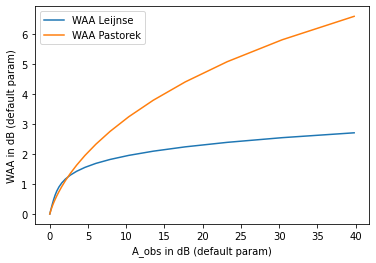

In [9]:
A_obs = np.logspace(-10, 1.6, 100)
A_obs[0] = 0

waa_leijnse = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=A_obs, L_km=10, pol='V', f_Hz=23e9,
)
waa_pastorek = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=A_obs, L_km=10, pol='V', f_Hz=23e9,
)

fig, ax = plt.subplots()
ax.plot(A_obs, waa_leijnse, label='WAA Leijnse')
ax.plot(A_obs, waa_pastorek, label='WAA Pastorek')

ax.set_xlabel('A_obs in dB (default param)')
ax.set_ylabel('WAA in dB (default param)')
ax.legend();

# WAA estimation for real CML data

Get example CML data

In [10]:
cml_list = pycml.io.examples.get_75_cmls()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:01<00:00, 67.64it/s]


## Estimate A_rain with the methods from above

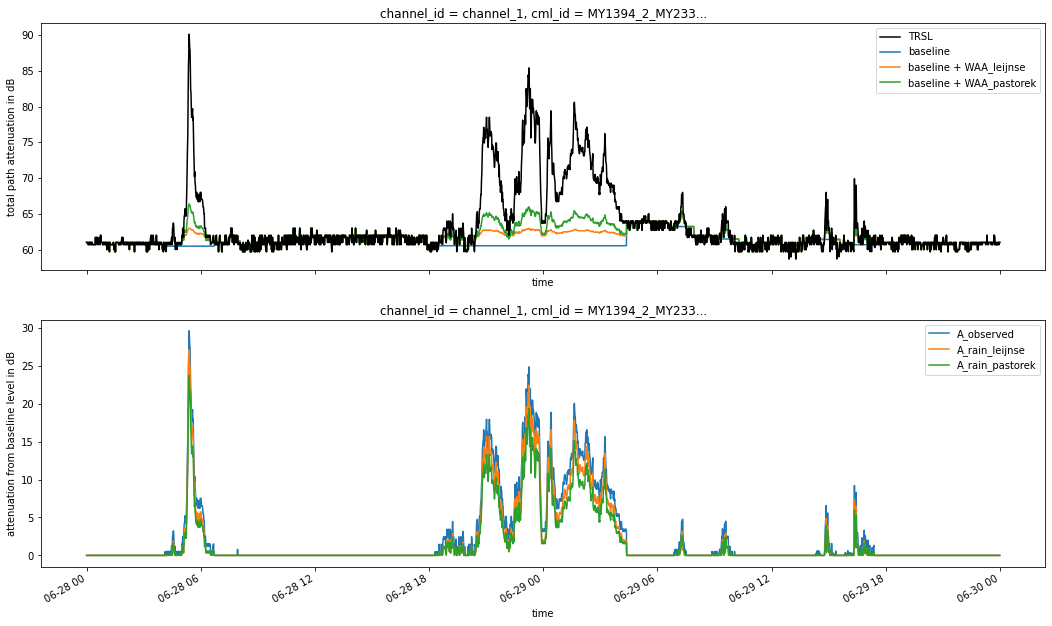

In [11]:
cml = cml_list[0]

cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
cml['trsl'] = cml.tsl - cml.rsl

cml['wet'] = cml.trsl.rolling(time=60, center=True).std(skipna=False) > 0.8

cml['wet_fraction'] = (cml.wet==1).sum() / (cml.wet==0).sum()

cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=cml.trsl, 
    wet=cml.wet, 
    n_average_last_dry=5,
)

cml['A'] = cml.trsl - cml.baseline
cml['A'] = cml.A.where(cml.A >= 0, 0)

cml['waa_leijnse'] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=cml.A,
    f_Hz=cml.frequency * 1e9,
    pol=cml.polarization,
    L_km=cml.length,
)

cml['waa_pastorek'] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=cml.A,
    f_Hz=cml.frequency * 1e9,
    pol=cml.polarization,
    L_km=cml.length,
)

cml['A_rain_leijnse'] = cml.trsl - cml.baseline - cml.waa_leijnse
cml['A_rain_leijnse'] = cml.A_rain_leijnse.where(cml.A_rain_leijnse >= 0, 0)

cml['A_rain_pastorek'] = cml.trsl - cml.baseline - cml.waa_pastorek
cml['A_rain_pastorek'] = cml.A_rain_pastorek.where(cml.A_rain_pastorek >= 0, 0)


fig, axs = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
plt.sca(axs[0])
cml.trsl.isel(channel_id=0).plot.line(x='time', label='TRSL', color='k', zorder=10)
cml.baseline.isel(channel_id=0).plot.line(x='time', label='baseline', color='C0')
(cml.baseline + cml.waa_leijnse).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_leijnse', color='C1')
(cml.baseline + cml.waa_pastorek).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_pastorek', color='C2')
plt.ylabel('total path attenuation in dB')
plt.legend()

plt.sca(axs[1])
cml.A.isel(channel_id=0).plot.line(x='time', label='A_observed', color='C0')
cml.A_rain_leijnse.isel(channel_id=0).plot.line(x='time', label='A_rain_leijnse', color='C1')
cml.A_rain_pastorek.isel(channel_id=0).plot.line(x='time', label='A_rain_pastorek', color='C2')
plt.ylabel('attenuation from baseline level in dB')
plt.legend();

# Compare rain-rate-dependent WAA estimation to time-dependent method from Schleiss et al 2013

[Schleiss et al 2013](https://ieeexplore.ieee.org/document/6451115) parametrizes the WAA as a function of time, with a defined rise rate to a maximum WAA value.

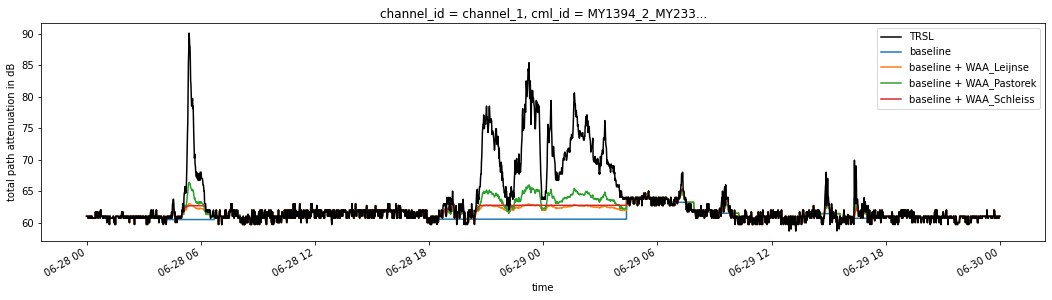

In [12]:
cml['waa_schleiss'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl,
    baseline=cml.baseline,
    wet=cml.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)

cml.trsl.isel(channel_id=0).plot.line(x='time', figsize=(18, 4), label='TRSL', color='k', zorder=10)
cml.baseline.isel(channel_id=0).plot.line(x='time', label='baseline', color='C0')

(cml.baseline + cml.waa_leijnse).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_Leijnse', color='C1')
(cml.baseline + cml.waa_pastorek).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_Pastorek', color='C2')
(cml.baseline + cml.waa_schleiss).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_Schleiss', color='C3')

plt.ylabel('total path attenuation in dB')
plt.legend();

# Compare resulting rain rates with different WAA methods to rain rates from radar reference

The radar reference is RADKLIM-YW from which we produced path-averaged values for each CML. More info on this procedure can be found in the notebook `Get radar rainfall along CML path`.

Note that RADKLIM-YW in our NetCDF is given as 5-minute rainfall sums.

In [13]:
%matplotlib inline

In [14]:
import xarray as xr
cmls = xr.open_dataset(pycml.io.examples.get_example_data_path() + '/example_cml_data.nc')
radar_along_cml = xr.open_dataset(pycml.io.examples.get_example_data_path() + '/example_path_averaged_reference_data.nc')

## Do CML processing with different WAA methods

Please note that:
* The wet-dry classification, which is done is a very simple way here, also plays a significant role for rain rates estimation.
* For a different CMLs, different WAA methods and different parameters might perform best.
* The radar rainfall reference cannot not be trusted 100% at its 5-minute resolution since the gauge-adjustment is done on hourly basis and then applied to the 5-min data. In addition, the radar reference might have larger uncertainty in regions far away from the gauges that have been used for the hourly adjustment. We have not included this info in our RADKLIM-YW dataset, hence, we have to treat the `radar_along_cml` equally for all CMLs. But, differences between CML and radar reference do not always mean the CML is wrong.

Below you can change the CML that is chosen and also play with different WAA parameters. You will find that there is no optimal solution for all CMLs, and that the wet-dry classification has a strong impact on the overall CML rainfall sum.

In [15]:
cml = cmls.isel(cml_id=338)

cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
cml['trsl'] = cml.tsl - cml.rsl
cml['trsl'] = cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

cml['wet'] = cml.trsl.rolling(time=60, center=True).std(skipna=False) > 0.6

cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=cml.trsl, 
    wet=cml.wet, 
    n_average_last_dry=5,
)

cml['A'] = cml.trsl - cml.baseline
cml['A'] = cml.A.where(cml.A >= 0, 0)

cml['waa_leijnse'] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=cml.A,
    f_Hz=cml.frequency,
    pol=cml.polarization,
    L_km=cml.length,
)

cml['waa_pastorek'] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=cml.A,
    f_Hz=cml.frequency,
    pol=cml.polarization,
    L_km=cml.length,
    A_max=5,
)

cml['waa_schleiss'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl,
    baseline=cml.baseline,
    wet=cml.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)

for waa_method in ['leijnse', 'pastorek', 'schleiss']:
    cml[f'A_rain_{waa_method}'] = cml.trsl - cml.baseline - cml[f'waa_{waa_method}']
    cml[f'A_rain_{waa_method}'] = cml[f'A_rain_{waa_method}'].where(cml[f'A_rain_{waa_method}'] >= 0, 0)
    cml[f'R_{waa_method}'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml[f'A_rain_{waa_method}'], L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization
    )
cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml.trsl - cml.baseline, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization,
)

## Plot time series of results with different WAA methods

In [16]:
# turn on interactive plots and zoom into some rain events
#%matplotlib widget

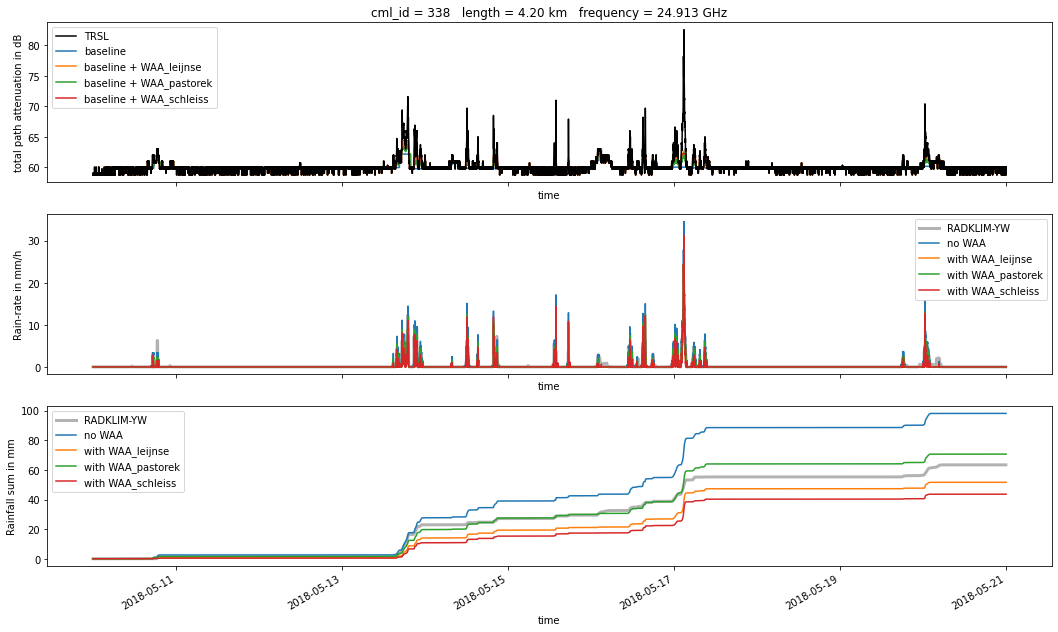

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
plt.sca(axs[0])
cml.trsl.isel(channel_id=0).plot.line(x='time', label='TRSL', color='k', zorder=10)
cml.baseline.isel(channel_id=0).plot.line(x='time', label='baseline', color='C0')
(cml.baseline + cml.waa_leijnse).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_leijnse', color='C1')
(cml.baseline + cml.waa_pastorek).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_pastorek', color='C2')
(cml.baseline + cml.waa_schleiss).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_schleiss', color='C3')
plt.ylabel('total path attenuation in dB')
plt.title(f'cml_id = {cml.cml_id}   length = {cml.length:2.2f} km   frequency = {cml.frequency.isel(channel_id=0)/1e9} GHz')
plt.legend()

plt.sca(axs[1])
(radar_along_cml.sel(cml_id=cml.cml_id.values).rainfall_amount * 12).plot.line(color='k', linewidth=3.0, label='RADKLIM-YW', alpha=0.3)
cml.R.isel(channel_id=0).plot.line(x='time', label='no WAA', color='C0')
cml.R_leijnse.isel(channel_id=0).plot.line(x='time', label='with WAA_leijnse', color='C1')
cml.R_pastorek.isel(channel_id=0).plot.line(x='time', label='with WAA_pastorek', color='C2')
cml.R_schleiss.isel(channel_id=0).plot.line(x='time', label='with WAA_schleiss', color='C3')
plt.ylabel('Rain-rate in mm/h')
plt.title('')
plt.legend()

plt.sca(axs[2])
radar_along_cml.sel(cml_id=cml.cml_id.values).rainfall_amount.cumsum(dim='time').plot.line(color='k', linewidth=3.0, label='RADKLIM-YW', alpha=0.3)
(cml.R.isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='no WAA', color='C0')
(cml.R_leijnse.isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='with WAA_leijnse', color='C1')
(cml.R_pastorek.isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='with WAA_pastorek', color='C2')
(cml.R_schleiss.isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='with WAA_schleiss', color='C3')
plt.ylabel('Rainfall sum in mm')
plt.title('')
plt.legend();

## Plot same data but as scatter plot

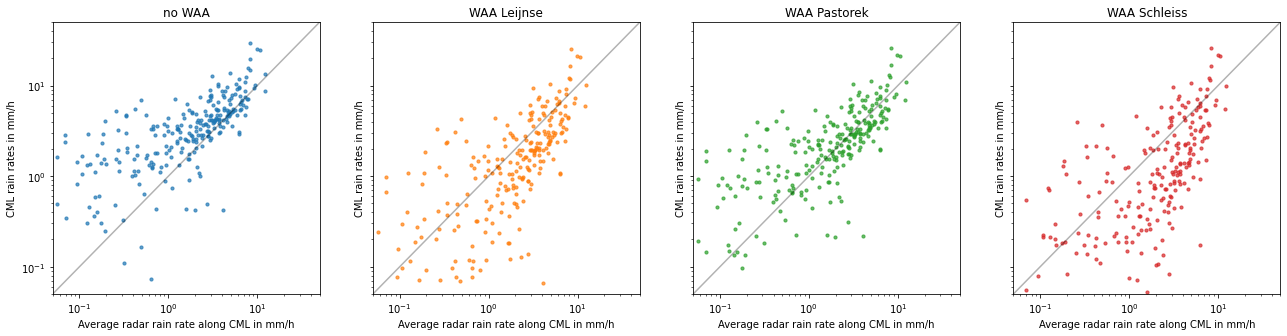

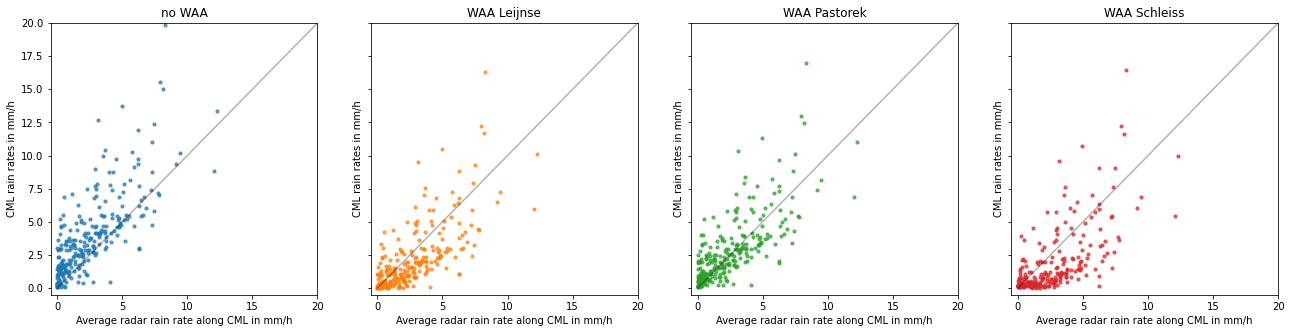

In [18]:
def hexbinplot(R_radar_along_cml, R_cml, ax, color='k', title=None, loglog=True):
    R_cml = R_cml.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
    R_cml.values[R_cml.values < 0] = 0
    #R_cml = R_cml.resample(time='1h').mean()
    #R_radar_along_cml = R_radar_along_cml.resample(time='1h').mean()
    ax.scatter(
        R_radar_along_cml.where(R_radar_along_cml > 0).values,
        R_cml.where(R_cml > 0).values,
        c=color,
        s=10,
        alpha=0.7,
    )
    if loglog:
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel('Average radar rain rate along CML in mm/h')
    ax.set_ylabel('CML rain rates in mm/h')


R_radar_along_cml = radar_along_cml.sel(cml_id=cml.cml_id).rainfall_amount * 12

fig, axs = plt.subplots(1, 4, figsize=(22, 5), sharex=True, sharey=True)

hexbinplot(R_radar_along_cml, cml.R, axs[0], 'C0', 'no WAA')
hexbinplot(R_radar_along_cml, cml.R_leijnse, axs[1], 'C1', 'WAA Leijnse')
hexbinplot(R_radar_along_cml, cml.R_pastorek, axs[2], 'C2', 'WAA Pastorek')
hexbinplot(R_radar_along_cml, cml.R_schleiss, axs[3], 'C3', 'WAA Schleiss')

for ax in axs:
    ax.plot([0.01, 50], [0.01, 50], 'k', alpha=0.3)
    ax.set_xlim(0.05, 50)
    ax.set_ylim(0.05, 50)

fig, axs = plt.subplots(1, 4, figsize=(22, 5), sharex=True, sharey=True)

loglog=False
hexbinplot(R_radar_along_cml, cml.R, axs[0], 'C0', 'no WAA', loglog=loglog)
hexbinplot(R_radar_along_cml, cml.R_leijnse, axs[1], 'C1', 'WAA Leijnse', loglog=loglog)
hexbinplot(R_radar_along_cml, cml.R_pastorek, axs[2], 'C2', 'WAA Pastorek', loglog=loglog)
hexbinplot(R_radar_along_cml, cml.R_schleiss, axs[3], 'C3', 'WAA Schleiss', loglog=loglog)

for ax in axs:
    ax.plot([0.01, 50], [0.01, 50], 'k', alpha=0.3)
    ax.set_xlim(-0.5, 20)
    ax.set_ylim(-0.5, 20)

## Check how different rain rates contribute to the accumulated rainfall sum

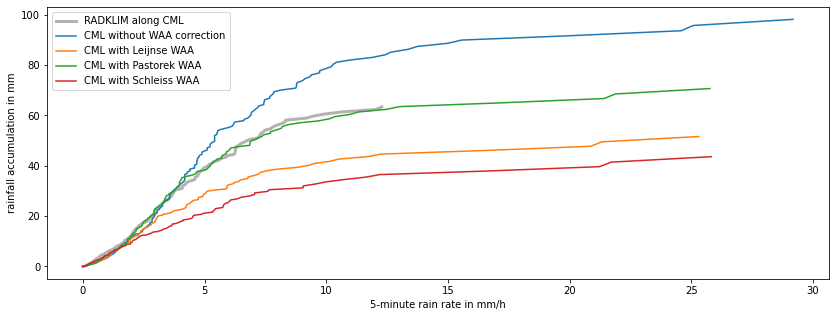

In [19]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(np.sort(R_radar_along_cml.values), np.sort(R_radar_along_cml.values / 12).cumsum(), label='RADKLIM along CML', color='k', alpha=0.3, linewidth=3)

R_cml = cml.R.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML without WAA correction')

R_cml = cml.R_leijnse.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML with Leijnse WAA')

R_cml = cml.R_pastorek.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML with Pastorek WAA')

R_cml = cml.R_schleiss.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML with Schleiss WAA')

plt.xlabel('5-minute rain rate in mm/h')
plt.ylabel('rainfall accumulation in mm')
plt.legend();
#plt.xscale('log')
#plt.xlim(0.1, 50)